<a href="https://colab.research.google.com/github/d-hetalpatel/news-bias-detection/blob/main/news_bias_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers sentence-transformers scikit-learn pandas seaborn matplotlib


In [22]:
# Install missing packages
# !pip install torch transformers sentence-transformers scikit-learn pandas seaborn matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [24]:
csv_path ='/content/drive/MyDrive/new_bias/news_bias_final_cleaned.csv'
df = pd.read_csv(csv_path)#pd.DataFrame(data, columns=["headline", "label"])
df


,headline,label
0,Taxing the ultra-wealthy is the only path to a...,left
1,Universal healthcare would save millions of fa...,left
2,Gig economy workers deserve full benefits and ...,left
3,The minimum wage must be increased to match th...,left
4,Corporate greed is the primary driver of curre...,left
...,...,...
1196,Public works to begin street paving in the cen...,neutral
1197,New recycling bins for paper and cardboard pla...,neutral
1198,Historical society uncovers an old ledger from...,neutral
1199,Local fire department holds its annual safety ...,neutral


In [25]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


In [26]:
df

,headline,label
0,Taxing the ultra-wealthy is the only path to a...,left
1,Universal healthcare would save millions of fa...,left
2,Gig economy workers deserve full benefits and ...,left
3,The minimum wage must be increased to match th...,left
4,Corporate greed is the primary driver of curre...,left
...,...,...
1194,Public works to begin street paving in the cen...,neutral
1195,New recycling bins for paper and cardboard pla...,neutral
1196,Historical society uncovers an old ledger from...,neutral
1197,Local fire department holds its annual safety ...,neutral


In [32]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
df


,headline,label,label_encoded
0,Taxing the ultra-wealthy is the only path to a...,left,0
1,Universal healthcare would save millions of fa...,left,0
2,Gig economy workers deserve full benefits and ...,left,0
3,The minimum wage must be increased to match th...,left,0
4,Corporate greed is the primary driver of curre...,left,0
...,...,...,...
1194,Public works to begin street paving in the cen...,neutral,1
1195,New recycling bins for paper and cardboard pla...,neutral,1
1196,Historical society uncovers an old ledger from...,neutral,1
1197,Local fire department holds its annual safety ...,neutral,1


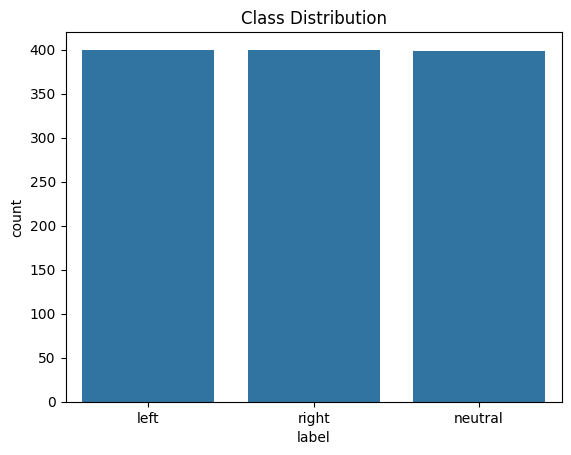

In [33]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()


In [37]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize headlines
encodings = tokenizer(df['headline'].tolist(), truncation=True, padding=True, max_length=32)


In [38]:
#PyTorch Dataset Class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = NewsDataset(encodings, df['label_encoded'].tolist())


In [39]:
#Load Pretrained Transformer for Classification
num_labels = len(df['label'].unique())
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
#Training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    #label_smoothing_factor=0.1,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
   # evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset
)

# Start training
trainer.train()

#manual evaluation
metrics = trainer.evaluate()
print(metrics)


Step,Training Loss
10,1.103500
20,1.087900
30,1.125300
40,1.083500
50,1.095200
60,1.095700
70,1.068600
80,1.042900
90,1.026800
100,0.992700


{'eval_loss': 0.03239161893725395, 'eval_runtime': 1.2219, 'eval_samples_per_second': 981.282, 'eval_steps_per_second': 122.763, 'epoch': 5.0}


In [41]:
model.eval()
model.to(device)

y_true = df['label_encoded'].tolist()
y_pred = []

for headline in df['headline']:
    inputs = tokenizer(
        headline,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=32
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred = torch.argmax(logits, dim=1).cpu().item()
    y_pred.append(pred)

In [42]:
#Inference on New Headlines
def predict(headline):
    model.eval()
    model.to(device)

    inputs = tokenizer(
        headline,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=32
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred_id = torch.argmax(logits, dim=1).cpu().item()
    return le.inverse_transform([pred_id])[0]

# Test
test_headlines = [
    "Government increases investment in renewable energy",
    "Local park gets new playground",
    "Taxes on businesses are too high"
]

for h in test_headlines:
    print(f"Headline: '{h}' → Predicted Bias: {predict(h)}")


Headline: 'Government increases investment in renewable energy' → Predicted Bias: left
Headline: 'Local park gets new playground' → Predicted Bias: neutral
Headline: 'Taxes on businesses are too high' → Predicted Bias: right


In [43]:
print(classification_report(
    y_true, y_pred,
    target_names=le.classes_,
    digits=3
))


              precision    recall  f1-score   support

        left      0.990     0.993     0.991       400
     neutral      1.000     1.000     1.000       399
       right      0.992     0.990     0.991       400

    accuracy                          0.994      1199
   macro avg      0.994     0.994     0.994      1199
weighted avg      0.994     0.994     0.994      1199



In [44]:
model.save_pretrained(
    "models/news_bias_model",
    safe_serialization=False
)
tokenizer.save_pretrained("models/news_bias_model")


('models/news_bias_model/tokenizer_config.json',
 'models/news_bias_model/special_tokens_map.json',
 'models/news_bias_model/vocab.txt',
 'models/news_bias_model/added_tokens.json',
 'models/news_bias_model/tokenizer.json')

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!cp -r models/news_bias_model /content/drive/MyDrive/
